In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(0)

In [2]:
def NN_plot(nn):
    nn.compile(loss = 'mse')
    xgrid = np.linspace(-20,20,401)
    y = nn.predict(xgrid)
    plt.plot(xgrid,y)
    plt.grid()
#     plt.show()

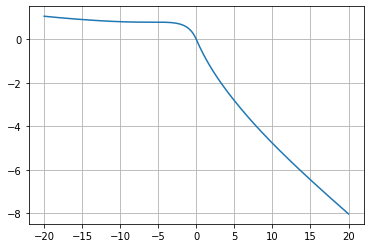

In [4]:
# Control Neural Network: u(x)

inputs = keras.Input(shape=(1))
l1 = layers.Dense(8, activation = 'elu')
l2 = layers.Dense(8, activation = 'elu')
l3= layers.Dense(1, activation = 'linear')
outputs = l1(inputs)
outputs = l2(outputs)
outputs = l3(outputs)
# outputs = -inputs
control_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'control_NN')
# control_NN.summary()
NN_plot(control_NN)

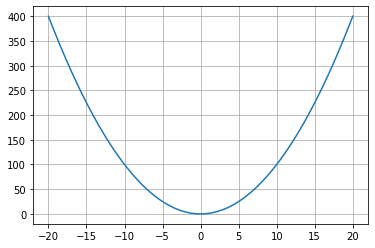

In [5]:
# Value Neural Network: V(x)

inputs = keras.Input(shape=(1))
l1 = layers.Dense(8, activation = 'elu')
l2 = layers.Dense(8, activation = 'elu')
l3= layers.Dense(1, activation = 'linear')
outputs = l1(inputs)
outputs = l2(outputs)
outputs = l3(outputs)
outputs = tf.math.square(inputs)
value_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'value_NN')
# value_NN.summary()
NN_plot(value_NN)

In [6]:
# Global Parameter
steps = 100
dt = 0.01
sqrtdt = np.sqrt(dt)
T = steps * dt
M = 1000

Let $X$ be controlled processes on $[0,\infty)$ meshed with $0 = t_{0} \leq t_{1} \leq \cdots $ with initial distribution $X_{0} \sim \mathcal{X}$ and $V_0, \rho_0$ initiated. 
     \begin{equation}
          \left\{
          \begin{aligned}
               \rho_{n} &=  \min_{u \in U}\frac{1}{\triangle t_{n+1}}\mathbb{E}\Big[\int_{t_{n}}^{t_{n+1}}c(X_{s},u_{s})ds + V_{n}(X_{t_{n+1}}) - V_{n}(X_{t_{n}})\Big]\\
               V_{n+1}(x) &= \min_{u\in U}\mathbb{E}\big[\int_{t_{n}}^{t_{n+1}}c(X_{s}^{x},u_{s})ds + V_{n}(X_{t_{n+1}}^x) -\rho_{n} \triangle t_{n+1} \big]
          \end{aligned}
          \right.
     \end{equation}

the number of points needed for grid increase exponentially with the growth of dimension of $x$. Therefore, meshing and Monte Carlo estimate leads to the curse of dimensionality. To avoid this, we attempt the machine learning approach computing the second line of algorithm
\begin{equation}
       V_{n+1}(x) = \arg\min_{V^{\theta} \in \mathcal{NN}}\mathbb{E}\Bigg[\Bigg( \int_{t_{n}}^{t_{n+1}}c(X_{s}^{x},u_{s})ds + V_{n}(X_{t_{n+1}}^x) -\rho_{n} \triangle t_{n+1} - V^{\theta}(X_{t_{n}}) \Bigg)^2\Bigg] \\
\end{equation}

In [7]:
# First line of algorithm

input_x = keras.Input(shape=(1))
inputs = [input_x]
X_start = input_x
X_now = X_start
loss = tf.zeros_like(X_now)
loss_output = [loss]

for i in range(steps):
    input_dW = keras.Input(shape=(1))
    inputs = inputs + [input_dW]
    u_now = control_NN(X_now)
    X_next  = X_now + input_dW + u_now * dt
    loss_tmp = (tf.math.square(X_now) + tf.math.square(u_now))*dt
    loss_output = loss_output + [loss_tmp]
    loss = loss + loss_tmp
    X_now = X_next
outputs = (loss + value_NN(X_now) - value_NN(X_start))/T

control_main = keras.Model(inputs=inputs, outputs = outputs, name = 'control_main')
control_terminal = keras.Model(inputs=inputs, outputs = X_now, name = 'control_terminal')
control_loss = keras.Model(inputs=inputs, outputs = loss_output, name = 'control_loss')
# control_loss.summary()

def mean_loss(target_y, predicted_y):
    return tf.reduce_mean(predicted_y - target_y)

control_main.compile(loss = mean_loss)
control_terminal.compile(loss = mean_loss)
control_loss.compile(loss = mean_loss)

In [8]:
def trainning_data(seed,X0,samplesM):
    np.random.seed(seed)
    x = [X0]
    for i in range(steps):
        x = x + [np.random.normal(0,sqrtdt,size = (samplesM,1))]
    y = np.zeros(shape = (samplesM,1))
    return x, y

In [9]:
np.random.seed(0)
# X0 = np.random.normal(0,1,size = (M,1))
X0 = np.random.normal(0,np.sqrt(1/2),size = (M,1))
# X0 = np.ones(shape = (M,1))
# X0 = np.zeros(shape = (M,1))
x_train, y_train = trainning_data(1,X0,M)
x_valid, y_valid = trainning_data(2,X0,M)
x_test, y_test = trainning_data(3,X0,M)

In [10]:
control_main.evaluate(x_train,y_train)

1000/1000 [==============================] - 3s 3ms/sample - loss: 1.0970


1.0970032358169555

In [11]:
control_main.fit(x_train,y_train,epochs = 20,validation_data = (x_valid,y_valid), verbose = 1)

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 14s 14ms/sample - loss: 1.0088 - val_loss: 1.0276
Epoch 2/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9821 - val_loss: 1.0246
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9808 - val_loss: 1.0228
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9794 - val_loss: 1.0227
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9783 - val_loss: 1.0219
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9781 - val_loss: 1.0207
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9778 - val_loss: 1.0196
Epoch 8/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9772 - val_loss: 1.0197
Epoch 9/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.9771 - val_loss: 1.0216
Epoch 10/20
10

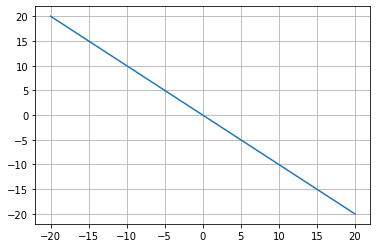

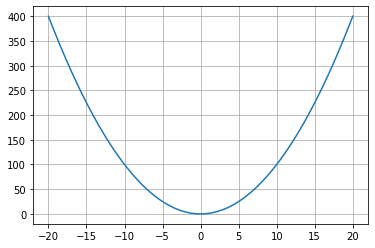

In [61]:
NN_plot(control_NN)
plt.show()
NN_plot(value_NN)
plt.show()